In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from nvae_layers import SqueezeExciteLayer
from nvae_layers import FactorizedDownsample
from nvae_layers import ResidualDecoderCell
from nvae_layers import ResidualEncoderCell
from nvae_layers import CombinerSampler
from nvae_layers import NvaeConv2D
from nvae_model import  create_nvae
from dataset_utils import LfwDataset

print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={tf.keras.__version__}')
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 0:
    print("No GPU(s) available")
else:
    print("GPU(s) Available: ") 
    for g in gpus:
        print('  ', g)

Using Python=3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
Using Tensorflow=2.3.0
Using Keras=2.4.0
GPU(s) Available: 
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
IMAGE_SIZE=(64, 64, 3)
BATCH_SIZE=64
LOAD_COUNT=2000  # set to None to use full dataset

In [4]:
lfw = LfwDataset()

print('Loading a sample of the dataset to check sizes')
lfw.tfds_load(load_count=100)
orig_shape = lfw.get_base_img_shape()
scalar = - orig_shape[-3] / IMAGE_SIZE[-3]

print()
print('Loading the full dataset, resampled/rescaled')
lfw.tfds_load(scale=scalar, load_count=LOAD_COUNT)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64

Loading a sample of the dataset to check sizes
Train samples: 80
Val samples:   10
Test samples:  10
lfw.data_sample.shape: (10, 160, 160, 3)

Loading the full dataset, resampled/rescaled
Train samples: 1600
Val samples:   200
Test samples:  200
lfw.data_sample.shape: (32, 64, 64, 3)


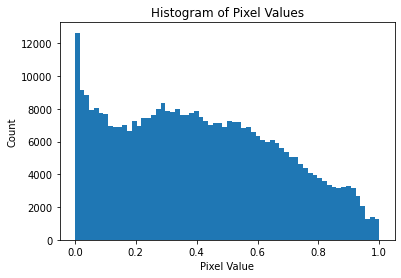

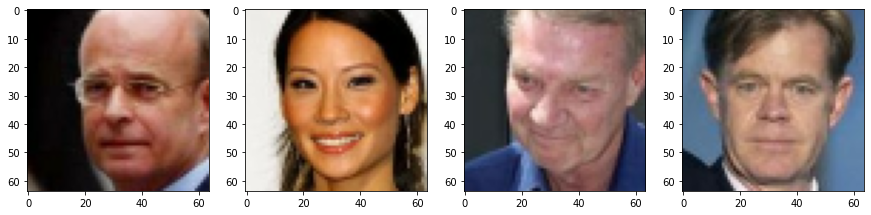

In [5]:
fig, ax = plt.subplots()
ax.hist(lfw.data_sample.reshape((-1,)), bins=64)
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Pixel Values')

fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].imshow(lfw.data_sample[i])

In [6]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=1, abs_channels=3)(x)

test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
nvae_conv2d (NvaeConv2D)     (None, 64, 64, 32)        928       
_________________________________________________________________
nvae_conv2d_1 (NvaeConv2D)   (None, 64, 64, 32)        9280      
_________________________________________________________________
nvae_conv2d_2 (NvaeConv2D)   (None, 64, 64, 32)        9280      
_________________________________________________________________
nvae_conv2d_3 (NvaeConv2D)   (None, 32, 32, 64)        2176      
_________________________________________________________________
nvae_conv2d_4 (NvaeConv2D)   (None, 32, 32, 64)        36992     
_________________________________________________________________
nvae_conv2d_5 (NvaeConv2D)   (None, 32, 32, 64)       

In [7]:
print('Pass thru 8 images:', test_model(lfw.data_sample[:8]).shape)

Pass thru 8 images: (8, 64, 64, 3)


In [8]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = NvaeConv2D(kernel_size=3, abs_channels=3)(x)
test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
nvae_conv2d_14 (NvaeConv2D)  (None, 64, 64, 32)        928       
_________________________________________________________________
residual_encoder_cell (Resid (None, 64, 64, 32)        19108     
_________________________________________________________________
residual_encoder_cell_1 (Res (None, 64, 64, 32)        19108     
_________________________________________________________________
residual_encoder_cell_2 (Res (None, 32, 32, 64)        58628     
_________________________________________________________________
residual_encoder_cell_3 (Res (None, 32, 32, 64)        75076     
_________________________________________________________________
residual_encoder_cell_4 (Res (None, 32, 32, 64)       

In [9]:
x = inputs = L.Input(shape=(16, 16, 3))
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = left = ResidualEncoderCell(downsample=True)(x)
x = ResidualEncoderCell(downsample=True)(x)
x = right = ResidualDecoderCell(upsample=True)(x)
x = CombinerSampler()([left, right])

test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 16, 16, 3)]  0                                            
__________________________________________________________________________________________________
nvae_conv2d_16 (NvaeConv2D)     (None, 16, 16, 32)   928         input_3[0][0]                    
__________________________________________________________________________________________________
residual_encoder_cell_6 (Residu (None, 8, 8, 64)     58628       nvae_conv2d_16[0][0]             
__________________________________________________________________________________________________
residual_encoder_cell_7 (Residu (None, 4, 4, 128)    232968      residual_encoder_cell_6[0][0]    
_______________________________________________________________________________________

In [10]:
test_model(lfw.data_sample[:4, :16, :16, :], training=True).shape

TensorShape([4, 8, 8, 64])

In [11]:
full_model = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=16,
    nscales=2,
    ngroups=2,
    ncells=2,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2)

print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=False).shape)
print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=True).shape)

Full model output shape: (4, 64, 64, 3)


Full model output shape: (4, 64, 64, 3)


In [15]:
full_model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
pre_stem (NvaeConv2D)           (None, 64, 64, 16)   464         input_4[0][0]                    
__________________________________________________________________________________________________
pre_blk0_c0 (ResidualEncoderCel (None, 64, 64, 16)   4948        pre_stem[0][0]                   
__________________________________________________________________________________________________
pre_blk0_c1 (ResidualEncoderCel (None, 32, 32, 32)   14980       pre_blk0_c0[0][0]                
_______________________________________________________________________________________

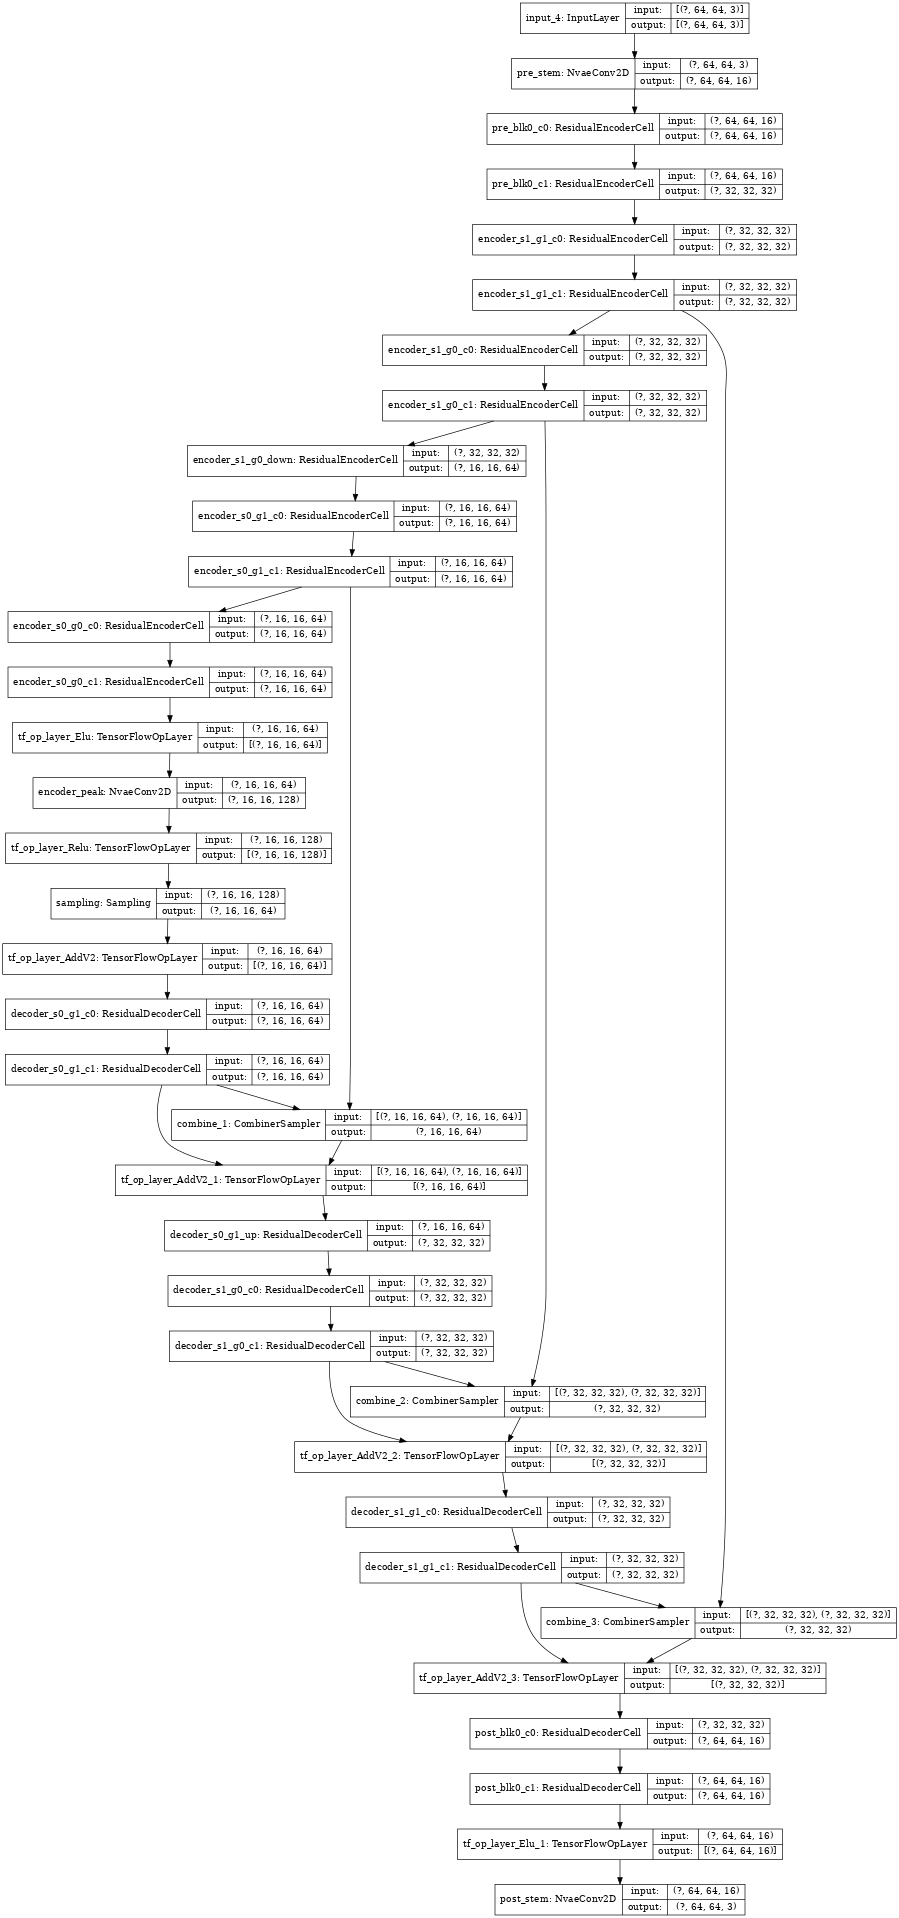

In [16]:
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48)
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48, to_file='small_nvae.png')

In [20]:
print('Loading the full dataset, resampled/rescaled')
lfw.tfds_load(scale=scalar, load_count=None)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64
train_xx, val_xx, test_xx = lfw.get_vae_data_splits(batch_size=64)

Loading the full dataset, resampled/rescaled
Train samples: 10586
Val samples:   1324
Test samples:  1323
lfw.data_sample.shape: (32, 64, 64, 3)


In [21]:
INITIAL_LR = 2e-4
full_nvae = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=16,
    nscales=2,
    ngroups=2,
    ncells=2,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2)

In [22]:
test_out = full_nvae(tf.zeros((64,) + IMAGE_SIZE))
opt = tf.keras.optimizers.Adamax(INITIAL_LR)
full_nvae.compile(opt, loss='mse', metrics='mse')

cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1)
cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
cb_chkpoint = tf.keras.callbacks.ModelCheckpoint('best_vae', monitor='val_loss', save_best_only=True, save_weights_only=True)

hist = full_nvae.fit(
    train_xx,
    validation_data=val_xx,
    epochs=50,
    callbacks=[cb_chkpoint, cb_earlystop, cb_reducelr])


full_nvae.load_weights('best_vae')

Epoch 1/50
166/166 [==============================] - 103s 623ms/step - loss: 0.4085 - mse: 0.3939 - val_loss: 0.0497 - val_mse: 0.0425
Epoch 2/50
166/166 [==============================] - 100s 601ms/step - loss: 0.1307 - mse: 0.1264 - val_loss: 0.0478 - val_mse: 0.0460
Epoch 3/50
166/166 [==============================] - 100s 601ms/step - loss: 0.0582 - mse: 0.0567 - val_loss: 0.0428 - val_mse: 0.0415
Epoch 4/50
166/166 [==============================] - 100s 600ms/step - loss: 0.0390 - mse: 0.0375 - val_loss: 0.0302 - val_mse: 0.0286
Epoch 5/50
166/166 [==============================] - 100s 601ms/step - loss: 0.0277 - mse: 0.0259 - val_loss: 0.0239 - val_mse: 0.0220
Epoch 6/50
166/166 [==============================] - 100s 601ms/step - loss: 0.0222 - mse: 0.0202 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 7/50
166/166 [==============================] - 100s 601ms/step - loss: 0.0188 - mse: 0.0167 - val_loss: 0.0159 - val_mse: 0.0139
Epoch 8/50
166/166 [============================

(array([  176.,  9889., 76135., 89191., 79571., 72870., 59299.,  5540.,
          429.,   116.]),
 array([-0.09334075,  0.0221882 ,  0.13771716,  0.2532461 ,  0.36877507,
         0.484304  ,  0.59983295,  0.7153619 ,  0.8308909 ,  0.94641984,
         1.0619488 ], dtype=float32),
 <BarContainer object of 10 artists>)

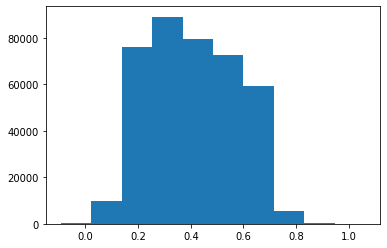

In [26]:
disp_ct = 8
nvae_proc = full_model(lfw.data_sample).numpy().reshape((-1,))
plt.hist(nvae_proc + 0.5)

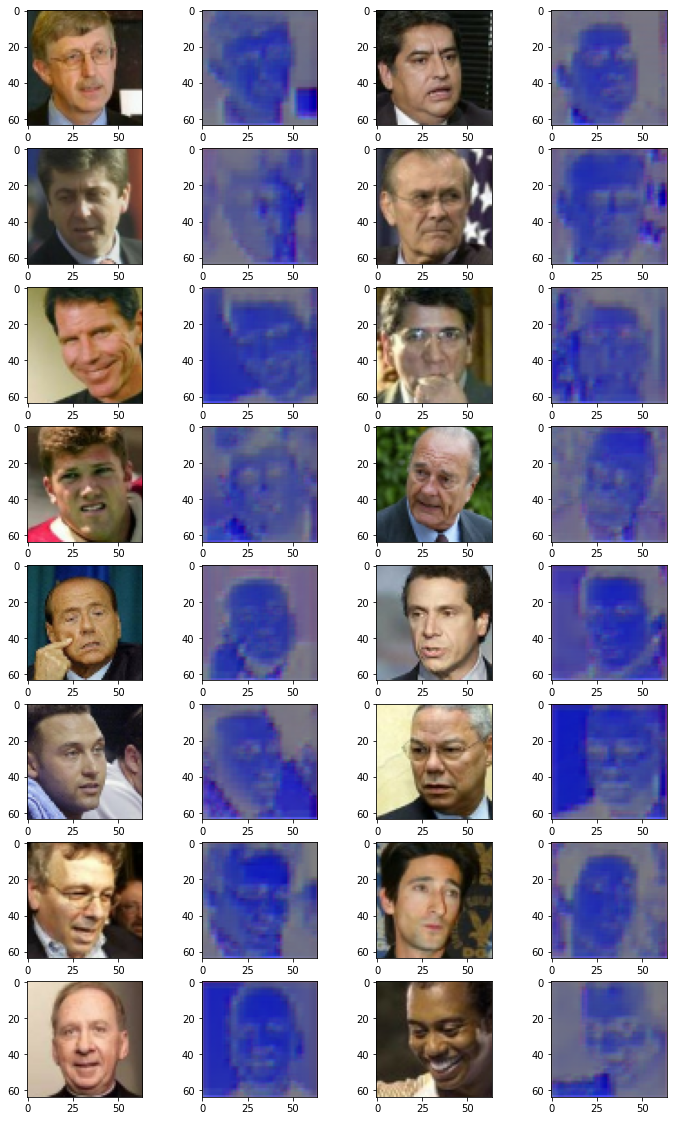

In [28]:
disp_ct = 4
nvae_proc = full_model(lfw.data_sample) + 0.5
fig, axs = plt.subplots(8, 4, figsize=(12, 20))
for a,i in enumerate(range(0, 16)):
    #print(lfw.data_sample[i].shape)
    #print(model_parts.encoder(tf.expand_dims(lfw.data_sample[i], axis=0)))
    orig = lfw.data_sample[i]
    vaed = nvae_proc[i]
    mrow = a//2
    mcol = a%2
    axs[mrow][mcol*2].imshow(lfw.unscale_img(orig))
    axs[mrow][mcol*2+1].imshow(lfw.unscale_img(vaed))

best_loss = min(hist.history['val_loss'])
    
fig.savefig(f'images/nvae_loss_{best_loss:.4f}_passthru.png')

In [20]:
test_input = cexpand(lfw.data_sample[:8])
test_nfilt = 32
#rdc = ResidualDecoderCell(expand_ratio=4, se_ratio=8, bn_momentum=0.9, gamma_reg=None)
cexpand = L.Conv2D(filters=test_nfilt, kernel_size=1, strides=1, padding='same')
test_input = cexpand(lfw.data_sample[:8])

rdc(test_input, training=True)
rdc(test_input, training=False)
print(test_input.shape)
dmodel = rdc.build(test_input.shape)
dmodel = rdc.create_model(test_input.shape[1:])
dmodel.summary()

ResDecCell build shape: (8, 160, 160, 32)
(8, 160, 160, 32)
ResDecCell build shape: (8, 160, 160, 32)


AttributeError: 'ResidualDecoderCell' object has no attribute 'conv_depth2'

In [ ]:
tf.keras.utils.plot_model(dmodel, show_shapes=True, dpi=48)

In [ ]:

rec = ResidualEncoderCell(se_ratio=8)
test_nfilt = 32
rec(test_input).shape
emodel = rec.create_model(test_input.shape[1:])
emodel.summary()

In [ ]:
tf.keras.utils.plot_model(emodel, show_shapes=True, dpi=48)